In [1408]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np


sns.plotting_context("talk")

produit = pd.read_csv("./data/products.csv")
client = pd.read_csv("./data/customers.csv")
vente = pd.read_csv("./data/transactions.csv")


vente = vente.drop(vente[vente.id_prod == 'T_0'].index)
vente['date'] = pd.to_datetime(vente['date'], format='%Y-%m-%d')


# Vérification des tables

# Produit

In [1409]:
print(produit.head(5))

  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0


In [1410]:
print(produit.shape)
print(produit.describe(include='all'))

(3287, 3)
       id_prod        price        categ
count     3287  3287.000000  3287.000000
unique    3287          NaN          NaN
top     0_1421          NaN          NaN
freq         1          NaN          NaN
mean       NaN    21.856641     0.370246
std        NaN    29.847908     0.615387
min        NaN    -1.000000     0.000000
25%        NaN     6.990000     0.000000
50%        NaN    13.060000     0.000000
75%        NaN    22.990000     1.000000
max        NaN   300.000000     2.000000


'id_prod' est bel et bien une clé primaire, car ils sont tous uniques.

Cependant, on peut remarquer que certains prix sont négatifs

In [1411]:
print(produit.sort_values(by='price'))

     id_prod   price  categ
731      T_0   -1.00      0
2355   0_202    0.62      0
2272   0_528    0.62      0
370    0_120    0.66      0
1211  0_1844    0.77      0
...      ...     ...    ...
2779    2_30  233.54      2
1436   2_167  236.99      2
394    2_158  247.22      2
724     2_76  254.44      2
947      2_2  300.00      2

[3287 rows x 3 columns]


On voit que le prix négatif correspond au produit 'T_0'

In [1412]:
produit = produit[produit['id_prod'] != 'T_0']
print(produit.shape)
print(produit.describe(include='all'))

(3286, 3)
       id_prod        price        categ
count     3286  3286.000000  3286.000000
unique    3286          NaN          NaN
top     0_1421          NaN          NaN
freq         1          NaN          NaN
mean       NaN    21.863597     0.370359
std        NaN    29.849786     0.615446
min        NaN     0.620000     0.000000
25%        NaN     6.990000     0.000000
50%        NaN    13.075000     0.000000
75%        NaN    22.990000     1.000000
max        NaN   300.000000     2.000000


In [1413]:
print("Les différentes valeurs de la colonne categ sont :",produit.categ.unique())

Les différentes valeurs de la colonne categ sont : [0 1 2]


# Client

In [1414]:
print(client.head(5))

  client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943


In [1415]:
print(client.shape)
print(client.describe(include='all'))

(8623, 3)
       client_id   sex        birth
count       8623  8623  8623.000000
unique      8623     2          NaN
top       c_4410     f          NaN
freq           1  4491          NaN
mean         NaN   NaN  1978.280877
std          NaN   NaN    16.919535
min          NaN   NaN  1929.000000
25%          NaN   NaN  1966.000000
50%          NaN   NaN  1979.000000
75%          NaN   NaN  1992.000000
max          NaN   NaN  2004.000000


De même pour 'client_id'

In [1416]:
print("Les différentes valeurs de la colonne sex sont :",client.sex.unique())

Les différentes valeurs de la colonne sex sont : ['f' 'm']


# Vente

In [1417]:
print(vente.head(5))

  id_prod                       date session_id client_id
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251 2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277 2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209 2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509 2023-01-11 08:22:08.194479   s_325227    c_4232


In [1418]:
print(vente.shape)
print(vente.describe(include='all'))

(679332, 4)


C:\Users\thebe\AppData\Local\Temp\ipykernel_18452\3198749870.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(vente.describe(include='all'))


       id_prod                        date session_id client_id
count   679332                      679332     679332    679332
unique    3266                      679332     342315      8600
top      1_369  2022-05-20 13:21:29.043970   s_118668    c_1609
freq      2252                           1         14     25488
first      NaN  2021-03-01 00:01:07.843138        NaN       NaN
last       NaN  2023-02-28 23:58:30.792755        NaN       NaN


# Fusion des Tables

In [1419]:
tableTotale = pd.merge(vente, produit, on='id_prod', how='left')
tableTotale = pd.merge(tableTotale, client, on='client_id', how='left')

print(f' vente shape is :{vente.shape}')
print(f' produit shape is :{produit.shape}')
print(f' client shape is :{client.shape}')
print(f' tableTotale shape is :{tableTotale.shape}')

 vente shape is :(679332, 4)
 produit shape is :(3286, 3)
 client shape is :(8623, 3)
 tableTotale shape is :(679332, 8)


# Ajout de nouvelles colonnes

Création d'une tranche d'age

In [1420]:
def arrondiDizaine(n):
    while n%10 !=0:
        n=n-1
    return n

In [1421]:
tableTotale['age'] = pd.DatetimeIndex(tableTotale['date']).year - tableTotale['birth']

In [1422]:
tableTotale['trancheAge'] = tableTotale['age'].apply(arrondiDizaine)

tableTotale.loc[tableTotale["trancheAge"] >= 100, "trancheAge"] = "100+"
tableTotale.loc[tableTotale["trancheAge"] == 10, "trancheAge"] = "10-20"
tableTotale.loc[tableTotale["trancheAge"] == 20, "trancheAge"] = "20-30"
tableTotale.loc[tableTotale["trancheAge"] == 30, "trancheAge"] = "30-40"
tableTotale.loc[tableTotale["trancheAge"] == 40, "trancheAge"] = "40-50"
tableTotale.loc[tableTotale["trancheAge"] == 50, "trancheAge"] = "50-60"
tableTotale.loc[tableTotale["trancheAge"] == 60, "trancheAge"] = "60-70"
tableTotale.loc[tableTotale["trancheAge"] == 70, "trancheAge"] = "70-80"
tableTotale.loc[tableTotale["trancheAge"] == 80, "trancheAge"] = "80-90"
tableTotale.loc[tableTotale["trancheAge"] == 90, "trancheAge"] = "90-100"


In [1423]:
print(tableTotale.sample(5))

       id_prod                       date session_id client_id  price  categ  \
503922   1_417 2022-04-19 06:16:45.407073   s_196234     c_610  20.99    1.0   
150185   1_153 2022-01-07 06:43:58.476201   s_146205     c_794  22.99    1.0   
50104    0_400 2022-12-01 13:46:39.897743   s_305573    c_6622   9.46    0.0   
262681   1_251 2022-01-29 20:37:52.512444   s_157084    c_2099  15.99    1.0   
605587   0_248 2022-11-14 02:34:18.753980   s_297285    c_5332   7.91    0.0   

       sex  birth  age trancheAge  
503922   m   1989   33      30-40  
150185   f   1974   48      40-50  
50104    m   1988   34      30-40  
262681   f   1964   58      50-60  
605587   f   1971   51      50-60  


In [1424]:
print(tableTotale.shape)
print(tableTotale.describe(include='all', datetime_is_numeric=True))

(679332, 10)
       id_prod                           date session_id client_id  \
count   679332                         679332     679332    679332   
unique    3266                            NaN     342315      8600   
top      1_369                            NaN   s_118668    c_1609   
freq      2252                            NaN         14     25488   
mean       NaN  2022-03-03 15:13:19.307389696        NaN       NaN   
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN   
25%        NaN  2021-09-08 09:14:25.055994368        NaN       NaN   
50%        NaN  2022-03-03 07:50:20.817730560        NaN       NaN   
75%        NaN  2022-08-30 23:57:08.555173888        NaN       NaN   
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN   
std        NaN                            NaN        NaN       NaN   

                price          categ     sex          birth            age  \
count   679111.000000  679111.000000  679332  679332.000000  679332.

On remarque qu'il y a des prix et des catégories qui ne sont pas renseignées

In [1425]:
print(tableTotale[tableTotale['price'].isna()]['id_prod'].unique())

['0_2245']


In [1426]:
print(produit[produit['id_prod'] == '0_2245'].shape)

(0, 3)


In [1427]:
print(vente[vente['id_prod'] == '0_2245'].shape)

(221, 4)


Ce produit n'apparait pas dans la table produit ce qui explique qui ne possède ni prix ni catégorie, pourtant il a été vendu 221 fois. Sur les 658664 ventes ce nombre est négligeable. D'autant plus si on remarque que le premier nombre de l'id produit correspond à la catégorie et que la catégorie 0 est la catégorie avec les prix les moins chères en moyenne.

In [1428]:
tableTotale = tableTotale[tableTotale['id_prod'] != '0_2245']

In [1429]:
print(tableTotale.shape)
print(tableTotale.describe(include='all', datetime_is_numeric=True))

(679111, 10)
       id_prod                           date session_id client_id  \
count   679111                         679111     679111    679111   
unique    3265                            NaN     342275      8600   
top      1_369                            NaN   s_118668    c_1609   
freq      2252                            NaN         14     25488   
mean       NaN  2022-03-03 15:15:06.328072704        NaN       NaN   
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN   
25%        NaN  2021-09-08 09:15:03.119490816        NaN       NaN   
50%        NaN  2022-03-03 07:40:49.314505984        NaN       NaN   
75%        NaN  2022-08-31 00:01:46.948335872        NaN       NaN   
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN   
std        NaN                            NaN        NaN       NaN   

                price          categ     sex          birth            age  \
count   679111.000000  679111.000000  679111  679111.000000  679111.

# Calcul du chiffre d'affaire

<AxesSubplot:xlabel='date', ylabel='semestre'>

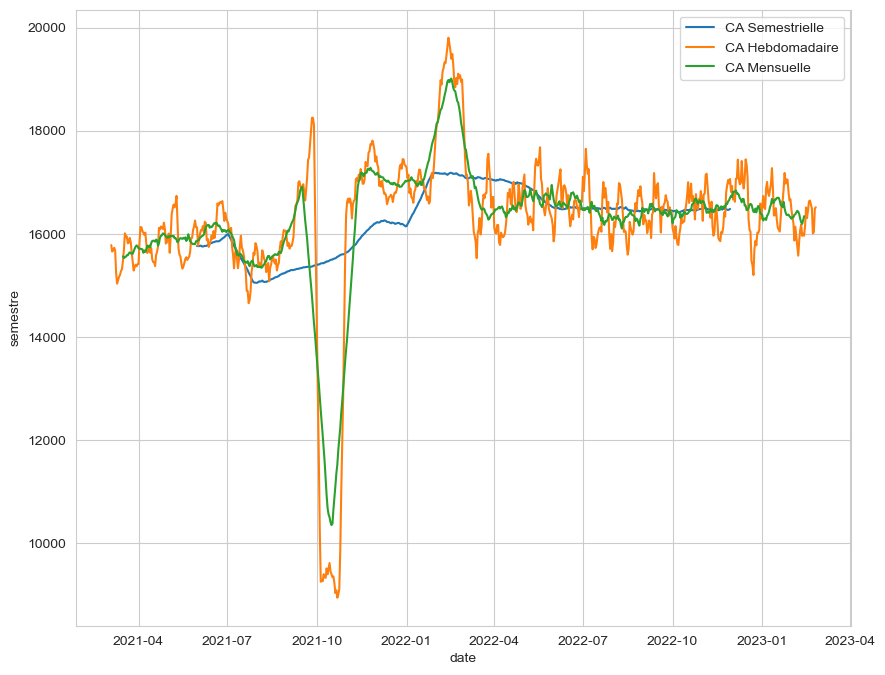

In [1430]:
chiffreAffaire = tableTotale[['price', 'date', 'id_prod', 'categ']].sort_values(by='date')
plt.figure(figsize=(10, 8))

chiffreAffaireJournalier = tableTotale[['price', 'date']].resample('D', on='date').sum()

chiffreAffaireJournalier['jour'] = chiffreAffaireJournalier['price'].rolling(1).mean().shift(0)
chiffreAffaireJournalier['semaine'] = chiffreAffaireJournalier['price'].rolling(7).mean().shift(-3)
chiffreAffaireJournalier['mois'] = chiffreAffaireJournalier['price'].rolling(31).mean().shift(-15)
chiffreAffaireJournalier['semestre'] = chiffreAffaireJournalier['price'].rolling(183).mean().shift(-91)

"""
sns.lineplot(x="date",y="price",
             label="CA Journalier", data=chiffreAffaireJournalier,
             ci=None)
"""
# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semestre",
             label="CA Semestrielle",
             data=chiffreAffaireJournalier,
             ci=None)

# 7-day rolling average Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semaine",
             label="CA Hebdomadaire",
             data=chiffreAffaireJournalier,
             ci=None)

# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="mois",
             label="CA Mensuelle",
             data=chiffreAffaireJournalier,
             ci=None)

# Nombre de Ventes par catégorie

<AxesSubplot:xlabel='date', ylabel='Count'>

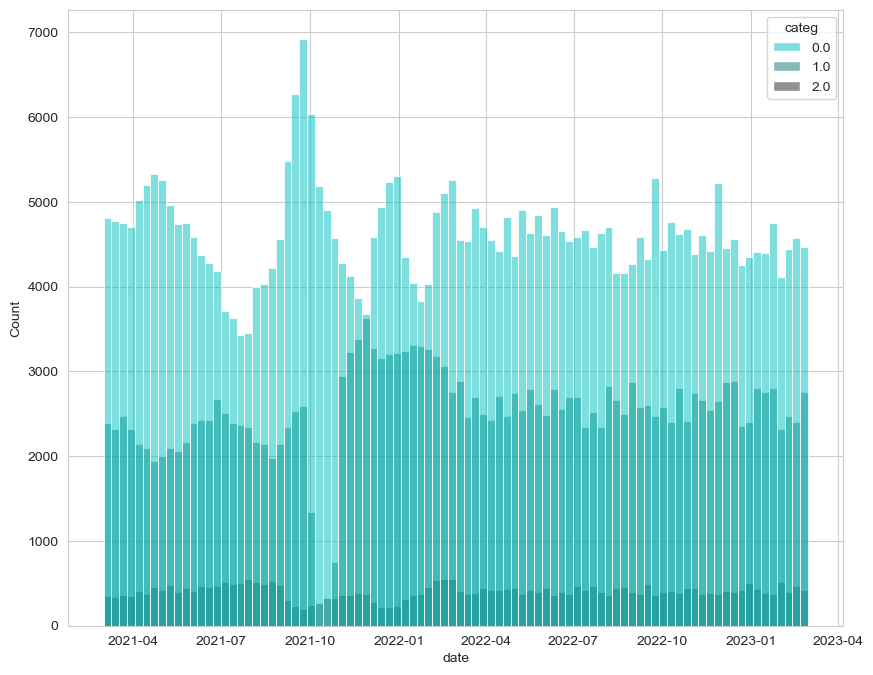

In [1431]:
plt.figure(figsize=(10,8))
sns.histplot(data=tableTotale, x='date', hue='categ',palette="dark:c_r")



Comme on peut le voir, il manque certaines données sur le mois d'octobre. On va donc complétement effacer les données du mois d'octobre 2021.

In [1432]:
tableTotale = tableTotale.drop(tableTotale[(tableTotale['date']>='2021-10-01') & (tableTotale['date']<='2021-10-31')].index)

# Calcul du nouveau chiffre d'affaires

<AxesSubplot:xlabel='date', ylabel='semestre'>

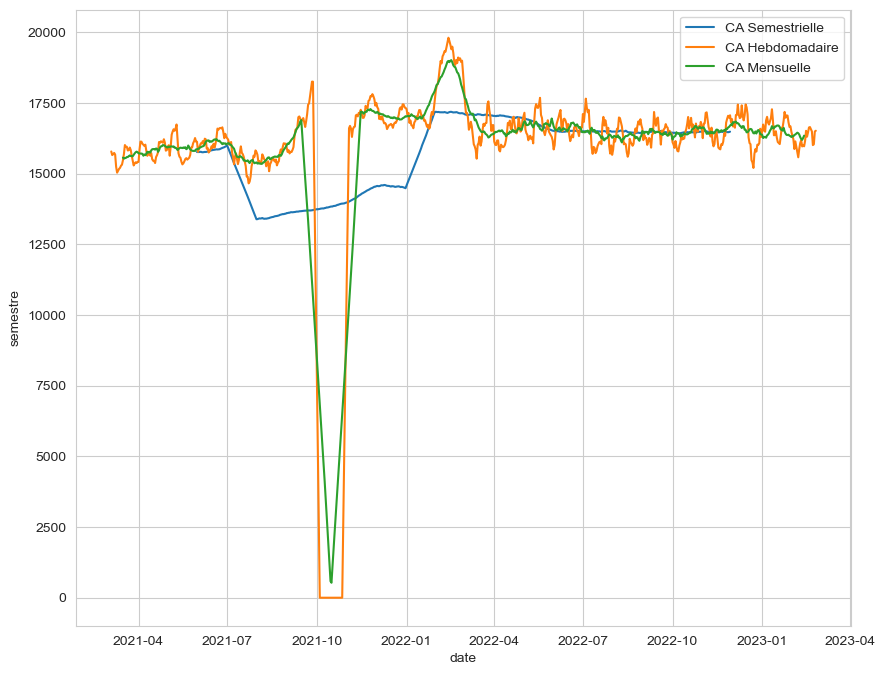

In [1433]:
chiffreAffaire = tableTotale[['price', 'date', 'id_prod', 'categ']].sort_values(by='date')
plt.figure(figsize=(10, 8))

chiffreAffaireJournalier = tableTotale[['price', 'date']].resample('D', on='date').sum()

chiffreAffaireJournalier['jour'] = chiffreAffaireJournalier['price'].rolling(1).mean().shift(0)
chiffreAffaireJournalier['semaine'] = chiffreAffaireJournalier['price'].rolling(7).mean().shift(-3)
chiffreAffaireJournalier['mois'] = chiffreAffaireJournalier['price'].rolling(31).mean().shift(-15)
chiffreAffaireJournalier['semestre'] = chiffreAffaireJournalier['price'].rolling(183).mean().shift(-91)

"""
sns.lineplot(x="date",y="price",
             label="CA Journalier", data=chiffreAffaireJournalier,
             ci=None)
"""
# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semestre",
             label="CA Semestrielle",
             data=chiffreAffaireJournalier,
             ci=None)

# 7-day rolling average Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semaine",
             label="CA Hebdomadaire",
             data=chiffreAffaireJournalier,
             ci=None)

# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="mois",
             label="CA Mensuelle",
             data=chiffreAffaireJournalier,
             ci=None)

# Nouvelles ventes par catégorie

<AxesSubplot:xlabel='date', ylabel='Count'>

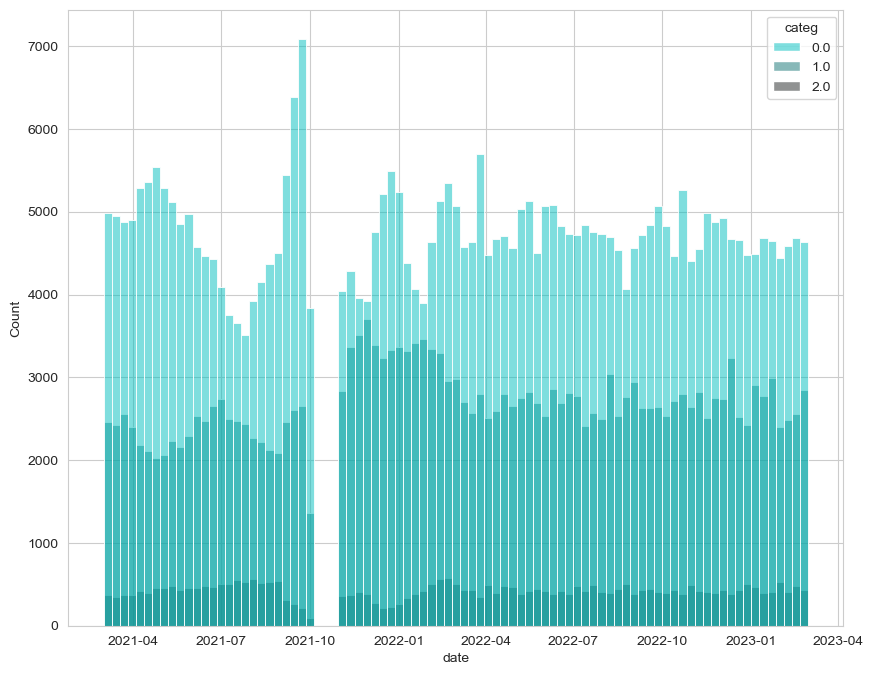

In [1434]:
plt.figure(figsize=(10,8))
sns.histplot(data=tableTotale, x='date', hue='categ',palette="dark:c_r")

# Ajout de la fréquence d'achat

Ajout du nombre d'achats moyen par mois

In [1435]:
max,min = tableTotale['date'].max(),tableTotale['date'].min()

nbMois = (max - min)/np.timedelta64(1, 'M')
nbMois = round(nbMois)

print("Les données s'étalent sur", nbMois,"mois,",nbMois-1, "si on ne prend pas en compte le mois d'octobre")

Les données s'étalent sur 24 mois, 23 si on ne prend pas en compte le mois d'octobre


On ajoute la fréquence d'achat en ignorant le mois d'octobre

In [1436]:
tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id').count()['date'].reset_index().rename(columns={'date': 'nombre d\'achats'}),
    how='left', on='client_id')

tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id')['date'].agg(['first']).reset_index().rename(columns={'first': 'date_inscription'}),
    how='left', on='client_id')

tableTotale['date_inscription'] = np.where(tableTotale['date_inscription']<'2021-10-01', tableTotale['date_inscription'] +  pd.DateOffset(months=1), tableTotale['date_inscription'])


tableTotale['ventes_mensuelles'] = round(tableTotale['nombre d\'achats'] / (((tableTotale['date'].max() - tableTotale['date_inscription'])/np.timedelta64(1, 'M'))),2)

print(tableTotale.describe(datetime_is_numeric=True))
print(tableTotale.sort_values(by='price'))

                                date          price          categ  \
count                         658450  658450.000000  658450.000000   
mean   2022-03-07 23:37:31.254899200      17.540185       0.450377   
min       2021-03-01 00:01:07.843138       0.620000       0.000000   
25%    2021-09-03 02:11:26.913094400       8.990000       0.000000   
50%    2022-03-14 12:04:02.457216768      13.990000       0.000000   
75%    2022-09-05 15:36:47.576642048      19.080000       1.000000   
max       2023-02-28 23:58:30.792755     300.000000       2.000000   
std                              NaN      18.338788       0.595752   

               birth            age  nombre d'achats  \
count  658450.000000  658450.000000    658450.000000   
mean     1977.776887      43.914656      1260.587653   
min      1929.000000      17.000000         1.000000   
25%      1970.000000      35.000000        63.000000   
50%      1980.000000      42.000000       119.000000   
75%      1987.000000      51.0000

(Importance des plus grosses fréquences d'achats)

# Chiffre d'affaire par produit

<AxesSubplot:ylabel='id_prod'>

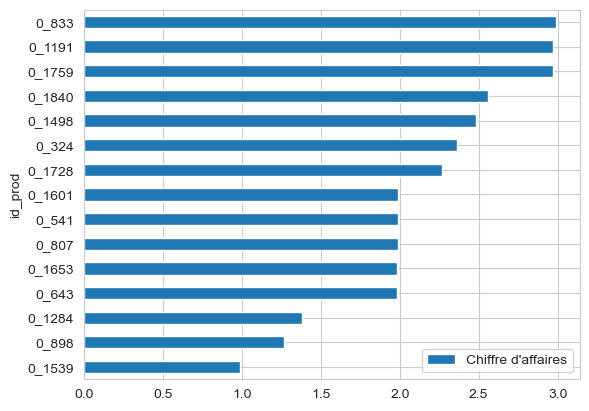

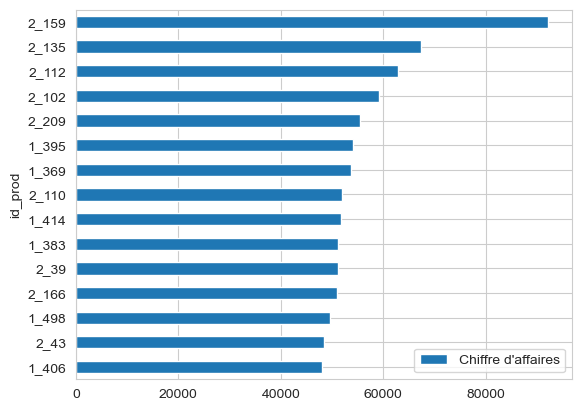

In [1437]:
# ----------------------------------------------------------------------------------------------------------------------
# Chiffre d'affaire par produit/catégorie ------------------------------------------------------------------------------

# chiffreAffaireProduit = chiffreAffaire.groupby(['id_prod'],
# pd.Grouper(key='date', axis=0, freq='M')).sum().rename(columns={"price": "Chiffre d'affaires"})

chiffreAffaireProduit = chiffreAffaire.copy(deep=True)
chiffreAffaireProduit.set_index('date')
chiffreAffaireProduit.index = pd.to_datetime(chiffreAffaireProduit.index)
chiffreAffaireProduit = chiffreAffaireProduit.groupby('id_prod').sum().sort_values(by='price').rename(columns={"price": "Chiffre d'affaires"})

chiffreAffaireProduit.head(15)[['Chiffre d\'affaires']].plot.barh()
chiffreAffaireProduit.tail(15)[['Chiffre d\'affaires']].plot.barh()

# Chiffre d'affaire par catégorie

In [1438]:
chiffreAffaire

,price,date,id_prod,categ
480501,11.99,2021-03-01 00:01:07.843138,0_1259,0.0
428350,19.37,2021-03-01 00:02:26.047414,0_1390,0.0
462563,4.50,2021-03-01 00:02:38.311413,0_1352,0.0
488153,6.55,2021-03-01 00:04:54.559692,0_1458,0.0
438944,16.49,2021-03-01 00:05:18.801198,0_1358,0.0
...,...,...,...,...
184602,21.92,2023-02-28 23:49:03.148402,1_508,1.0
588008,48.99,2023-02-28 23:51:29.318531,2_37,2.0
130140,26.99,2023-02-28 23:53:18.929676,1_695,1.0
550293,8.99,2023-02-28 23:58:00.107815,0_1547,0.0


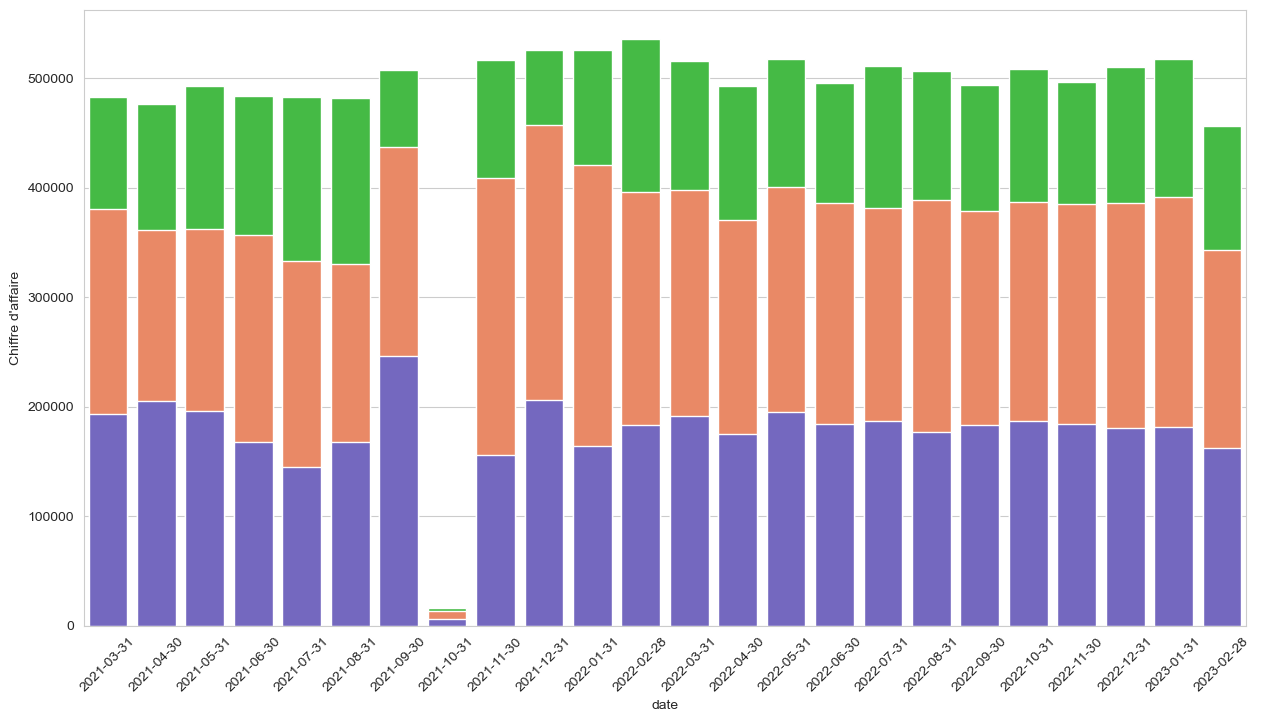

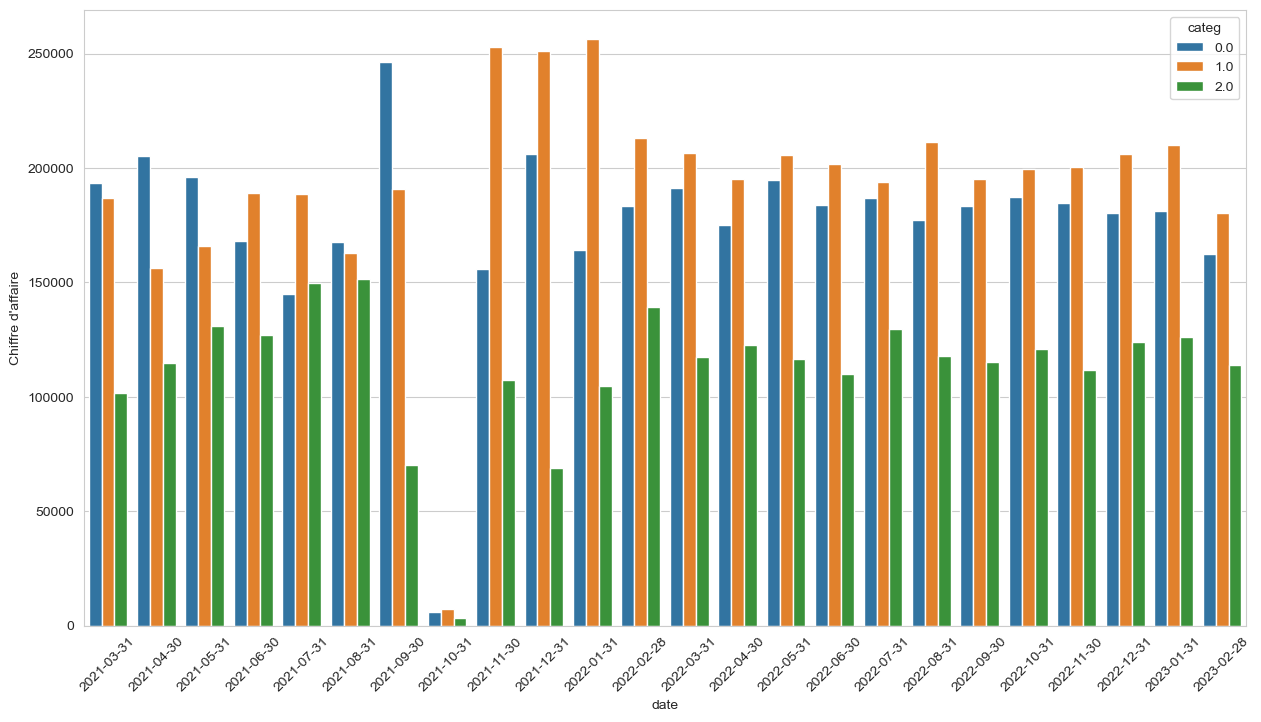

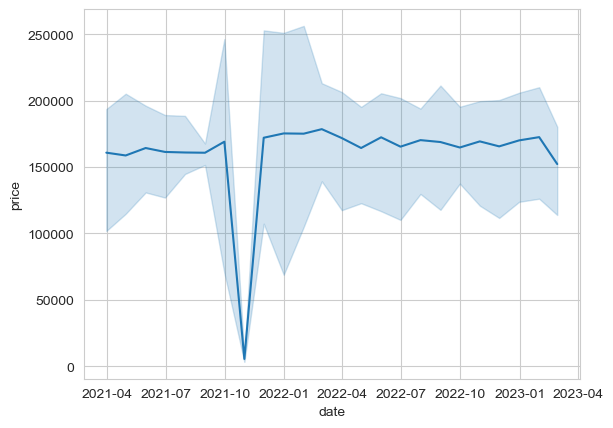

          date  categ      price
0   2021-03-31    0.0  193629.17
1   2021-03-31    1.0  186974.17
2   2021-03-31    2.0  101837.27
3   2021-04-30    0.0  205222.46
4   2021-04-30    1.0  156138.35
..         ...    ...        ...
67  2023-01-31    1.0  210104.41
68  2023-01-31    2.0  126153.08
69  2023-02-28    0.0  162457.00
70  2023-02-28    1.0  180347.24
71  2023-02-28    2.0  113875.52

[72 rows x 3 columns]


In [1439]:
plt.figure(figsize=(15,8))
chiffreAffaireCategorie = chiffreAffaire.groupby(by=[pd.Grouper(key='date', freq='M'), 'categ'])['price'].sum().unstack(fill_value=0).reset_index()
chiffreAffaireCategorie['date'] = pd.to_datetime(chiffreAffaireCategorie['date']).dt.date
chiffreAffaireCategorie[1.0] = chiffreAffaireCategorie[1.0] + chiffreAffaireCategorie[0.0]
chiffreAffaireCategorie[2.0] = chiffreAffaireCategorie[1.0] + chiffreAffaireCategorie[2.0]

Cat2 = sns.barplot(x = 'date', y = 2.0, data = chiffreAffaireCategorie, color = 'limegreen')
Cat1 = sns.barplot(x = 'date', y = 1.0, data = chiffreAffaireCategorie, color = 'coral')
Cat0 = sns.barplot(x = 'date', y = 0.0, data = chiffreAffaireCategorie, color = 'slateblue')

plt.ylabel('Chiffre d\'affaire')
plt.xticks(rotation=45)


chiffreAffaireCategorie = chiffreAffaire.copy(deep=True)

plt.figure(figsize=(15,8))
chiffreAffaireCategorie = chiffreAffaireCategorie.groupby(by=[pd.Grouper(key='date', freq='M'), 'categ'])['price'].sum().reset_index()#.unstack(fill_value=0)##
chiffreAffaireCategorie['date'] = pd.to_datetime(chiffreAffaireCategorie['date']).dt.date

sns.barplot(data=chiffreAffaireCategorie,x='date',y='price',hue='categ')
plt.xticks(rotation=45)
plt.ylabel('Chiffre d\'affaire')
plt.show()

sns.lineplot(data=chiffreAffaireCategorie,x='date',y='price')
#chiffreAffaireCategorie.plot.bar(stacked=True, x='date')
plt.show()
print(chiffreAffaireCategorie)



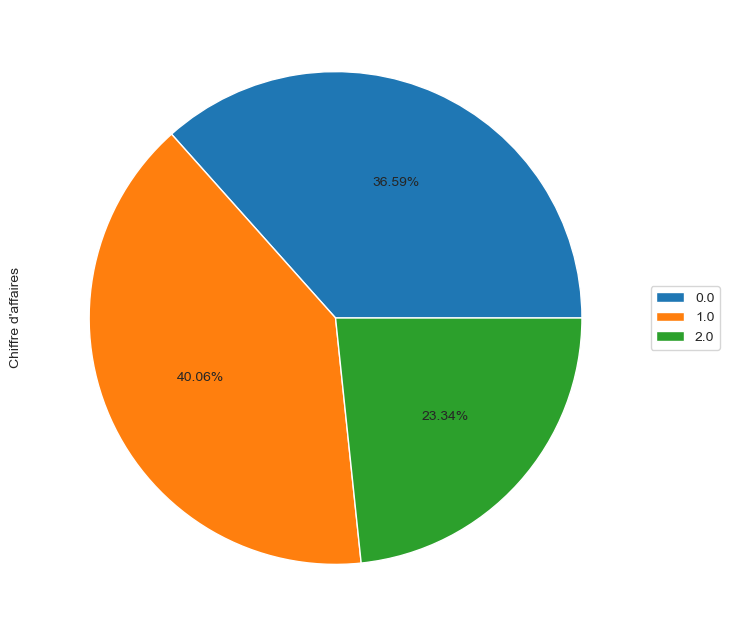

In [1440]:

chiffreAffaireCategorie = chiffreAffaire.groupby(by='categ')['price'].sum().rename("Chiffre d'affaires")
chiffreAffaireCategorie.plot.pie(autopct=lambda diapo: str(round(diapo, 2)) + '%',labeldistance=None,figsize=(8,8),title=None).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# Répartition des clients

# Courbe de Lorenz

In [1441]:
def lorenz(variable, title):
    X = variable.values
    X = np.sort(X)

    # Indice de Gini
    def gini(array):
        sorted_array = array.copy()
        sorted_array.sort()
        n = array.size
        coef_ = 2. / n
        const_ = (n + 1.) / n
        weighted_sum = sum([(i + 1) * yi for i, yi in enumerate(sorted_array)])
        return coef_ * weighted_sum / (sorted_array.sum()) - const_

    print('Incide de Gini :', gini(X))

    # Courbe de Lorenz
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    # X_lorenz[0], X_lorenz[-1]
    y = np.arange(X_lorenz.size) / (X_lorenz.size - 1)
    lorenz = pd.DataFrame()
    lorenz['X'] = pd.Series(X_lorenz)
    lorenz['Y'] = pd.Series(y)
    sns.scatterplot(data=lorenz, x='Y', y='X', marker='x')

    # Diagonale
    a = np.arange(0, 1, .01)
    x = a
    y = a

    # Graphique
    sns.lineplot(x=x, y=y)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(title)
    plt.show()

Incide de Gini : 0.4471794388153374


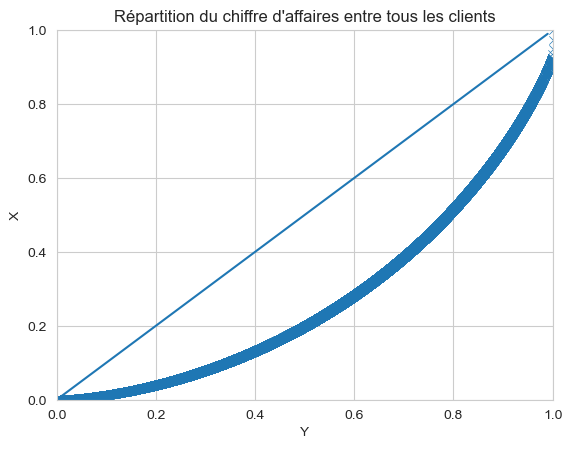

In [1442]:

# ----------------------------------------------------------------------------------------------------------------------
# Courbe de Lorenz -----------------------------------------------------------------------------------------------------

chiffreAffaireClient = tableTotale.groupby('client_id')['price'].sum().rename('chiffre d\'affaire').sort_values()

lorenz(chiffreAffaireClient, 'Répartition du chiffre d\'affaires entre tous les clients')

# Corrélation entre les caractéristiques

<AxesSubplot:>

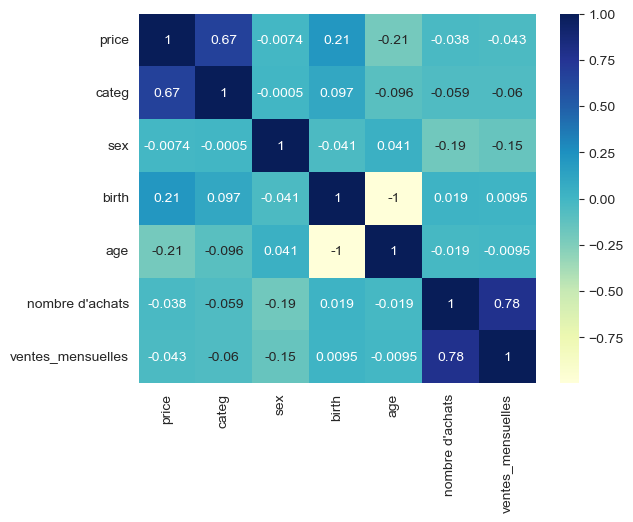

In [1443]:
#Lien entre données
sns.heatmap(tableTotale.replace({"m": 0,"f": 1}).corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

price    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

<Figure size 1000x1000 with 0 Axes>

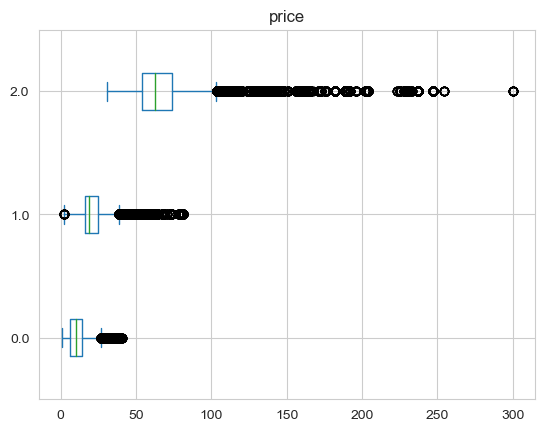

In [1444]:
#Prix/catégorie
plt.figure(figsize=(10,10))
chiffreAffaire.plot.box(column="price", by="categ", vert=False, showfliers=True)

price    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

<Figure size 1000x1000 with 0 Axes>

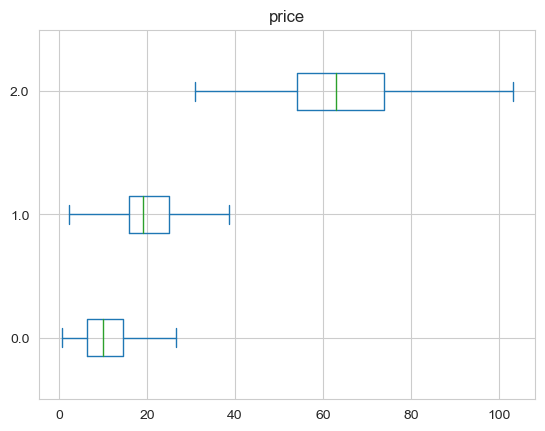

In [1445]:
#Prix/catégorie
plt.figure(figsize=(10,10))
chiffreAffaire.plot.box(column="price", by="categ", vert=False, showfliers=False)

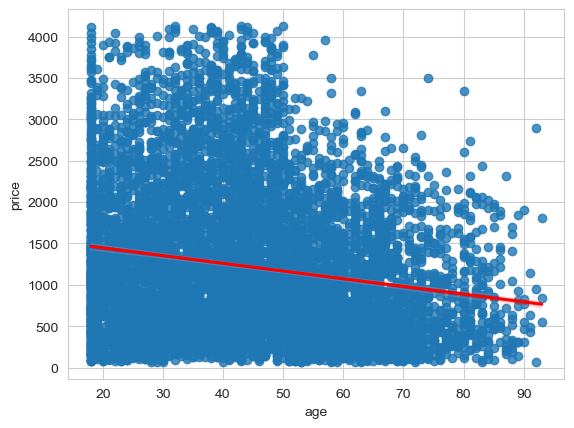

In [1446]:
# ----------------------------------------------------------------------------------------------------------------------
# Lien entre age et montant des achats ---------------------------------------------------------------------------------

ageMontant = tableTotale[['client_id', 'birth', 'price', 'sex']].groupby(by=['client_id', 'birth', 'sex'], as_index=False)['price'].sum()
ageMontant['age'] = 2022 - ageMontant['birth']
ageMontant = ageMontant[ageMontant.price.between(ageMontant.price.quantile(.01), ageMontant.price.quantile(.99))]
sns.regplot(x="age", y="price", data=ageMontant, line_kws={'color': 'red'})
plt.show()

# Prix en fonction de l'age

[Text(0.5, 0, 'Age'), Text(0, 0.5, 'Prix moyen du livre acheté')]

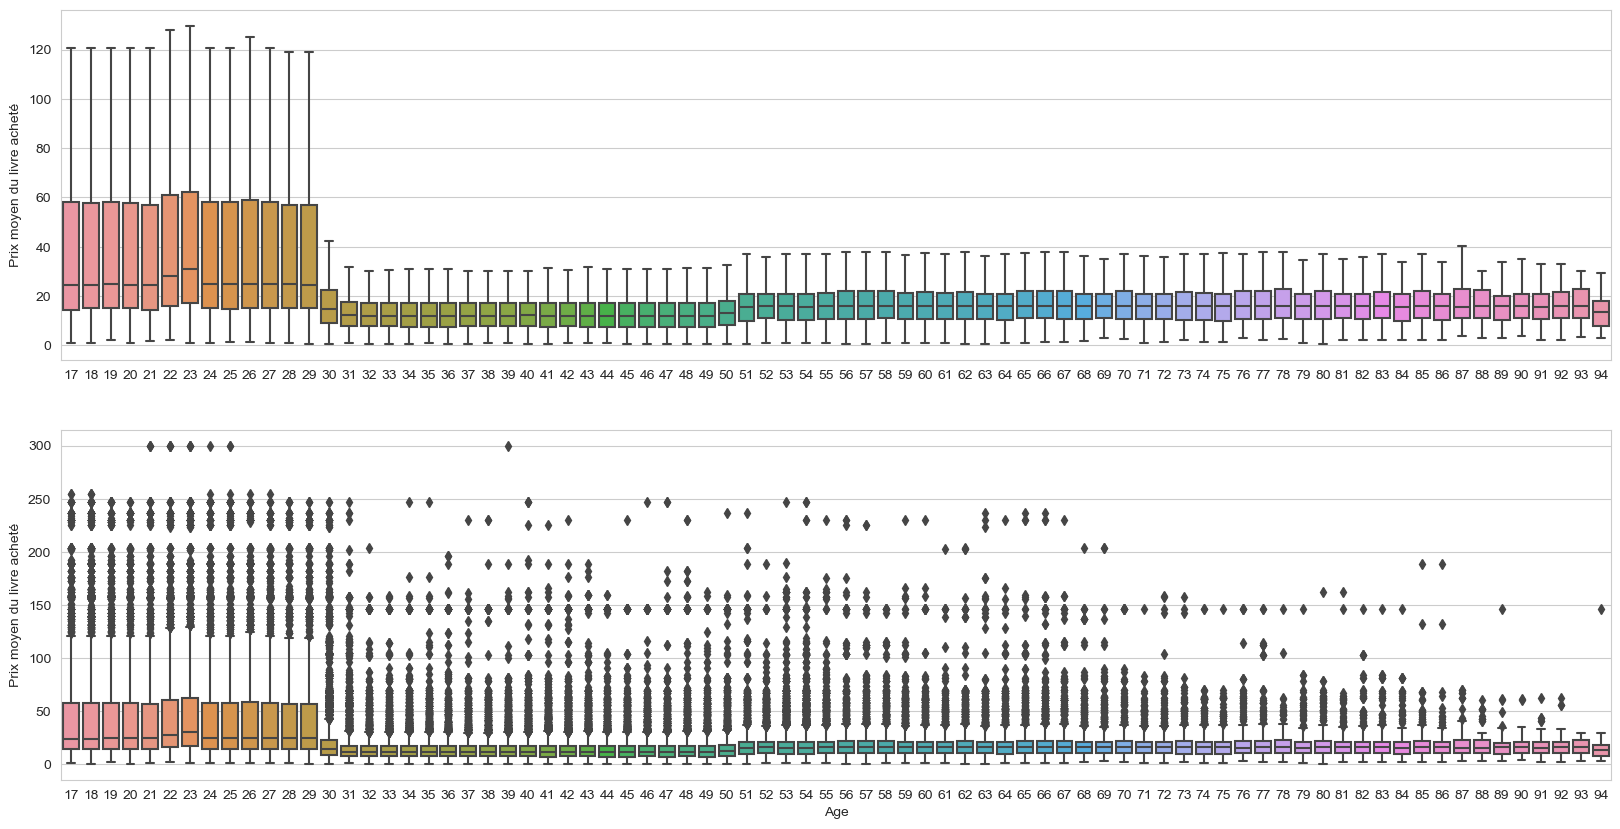

In [1447]:
f, (ax_box1, ax_box) = plt.subplots(2, sharex=False, gridspec_kw={"height_ratios": (.5, .5)},  figsize=(20,10))

sns.boxplot(data=tableTotale, x='age',y='price',ax=ax_box1, showfliers=False)
sns.boxplot(data=tableTotale, x='age',y='price',ax=ax_box)

ax_box1.set(xlabel='',ylabel='Prix moyen du livre acheté')
ax_box.set(xlabel='Age',ylabel='Prix moyen du livre acheté')

[Text(0.5, 0, "Tranche d'age"), Text(0, 0.5, 'Prix moyen du livre acheté')]

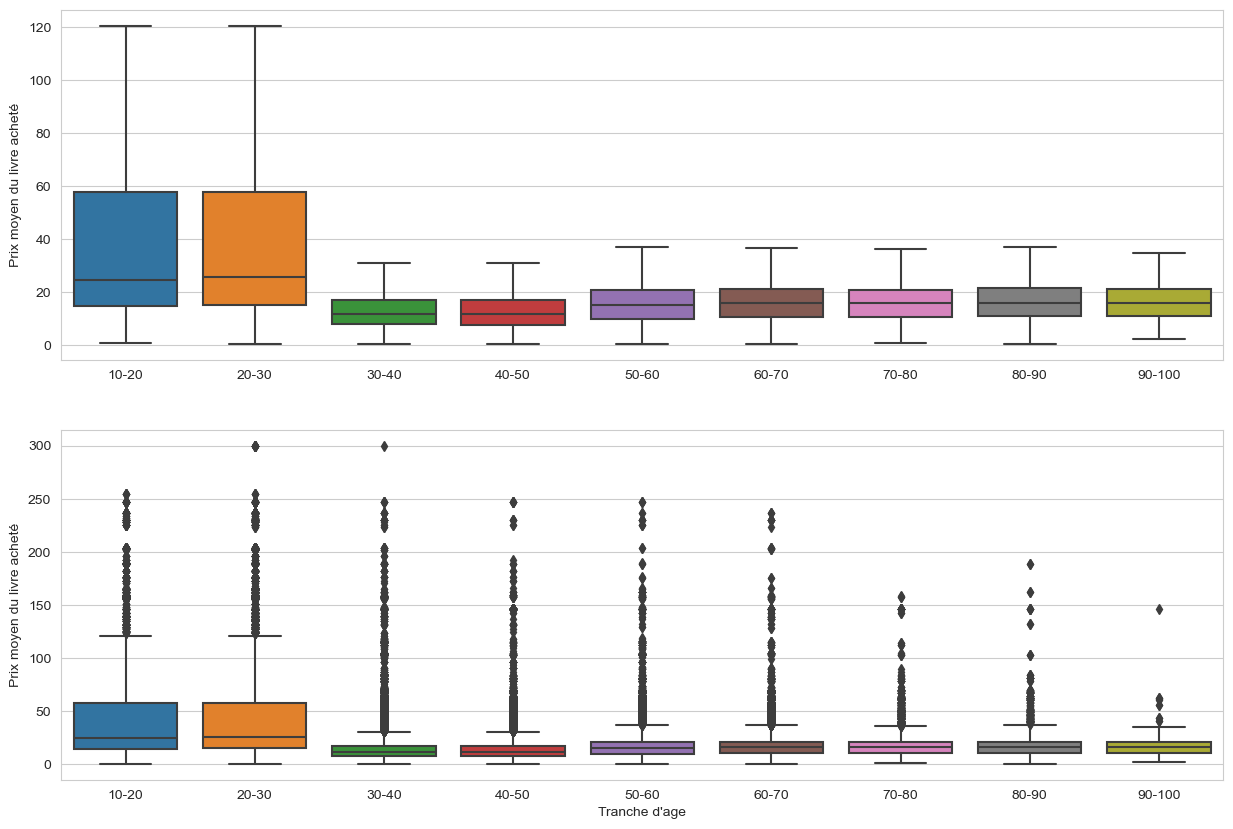

In [1448]:
f, (ax_box1, ax_box) = plt.subplots(2, sharex=False, gridspec_kw={"height_ratios": (.5, .5)},  figsize=(15,10))

sns.boxplot(data=tableTotale.sort_values(by='trancheAge'), x='trancheAge',y='price',ax=ax_box1, showfliers=False)
sns.boxplot(data=tableTotale.sort_values(by='trancheAge'), x='trancheAge',y='price',ax=ax_box)

ax_box1.set(xlabel='',ylabel='Prix moyen du livre acheté')
ax_box.set(xlabel='Tranche d\'age',ylabel='Prix moyen du livre acheté')



# Lien entre age et catégorie

<AxesSubplot:xlabel='age', ylabel='Count'>

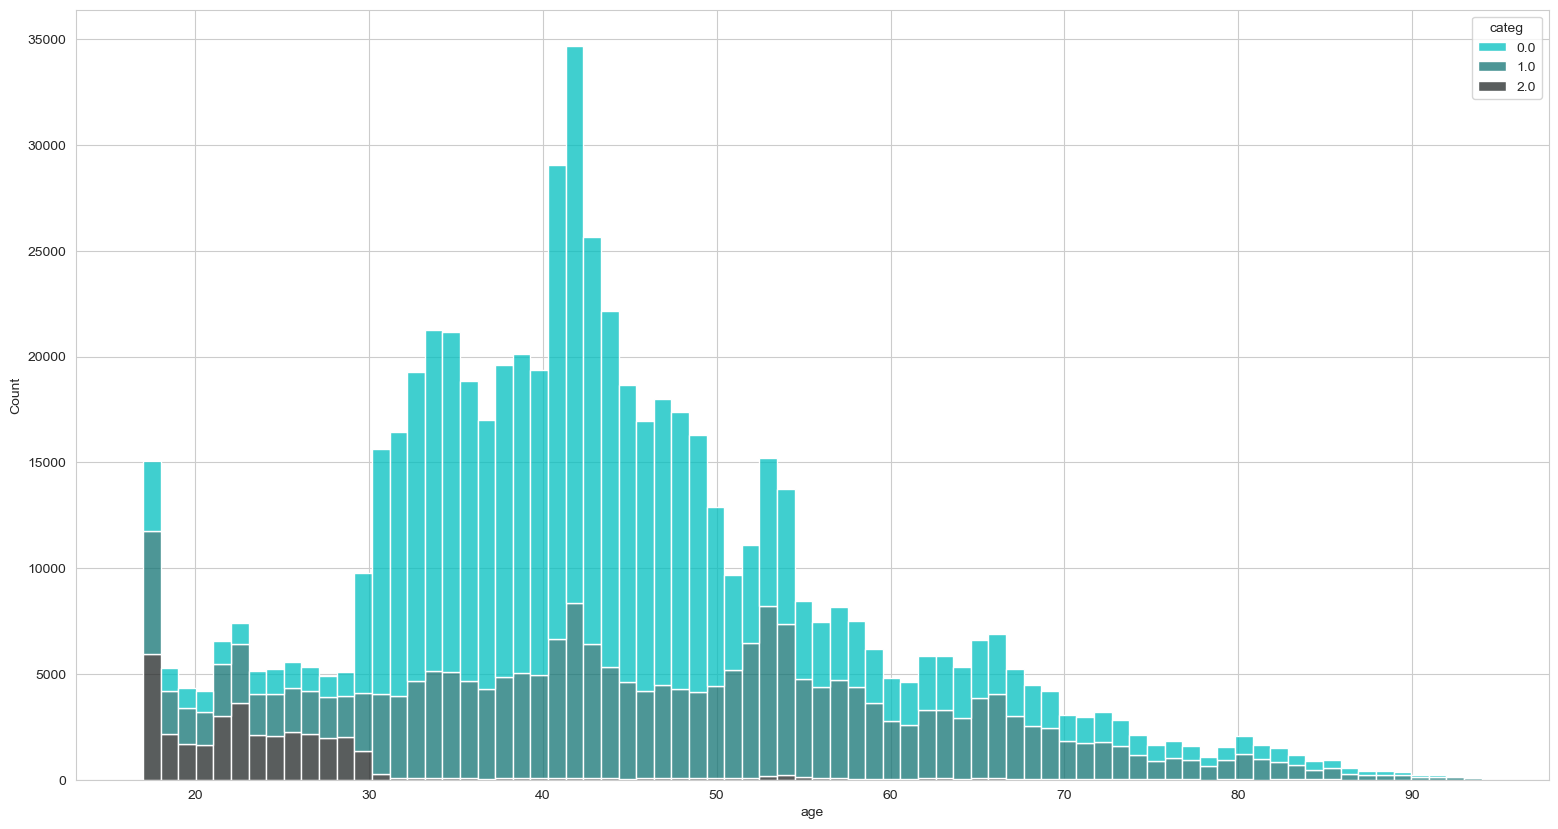

In [1449]:
plt.figure(figsize=(19,10))
sns.histplot(data=tableTotale.sort_values(by='age'), x='age', hue='categ',bins=93-17,palette="dark:c_r",multiple='stack')

<AxesSubplot:xlabel='trancheAge', ylabel='Count'>

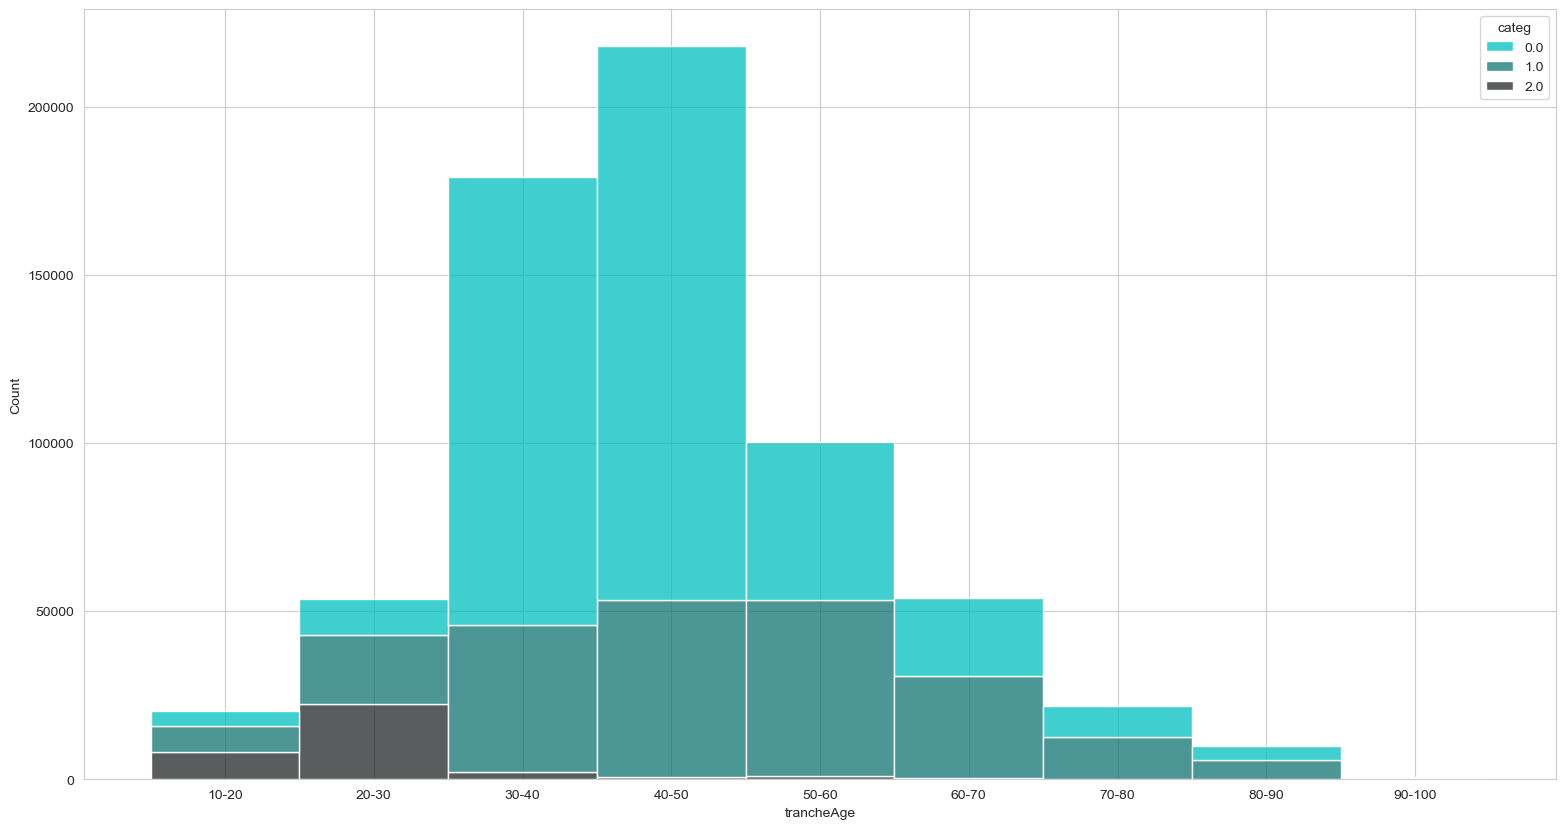

In [1450]:
plt.figure(figsize=(19,10))
sns.histplot(data=tableTotale.sort_values(by='trancheAge'), x='trancheAge', hue='categ',palette="dark:c_r",multiple='stack')

# Lien entre catégorie et genre

<AxesSubplot:xlabel='sex', ylabel='Count'>

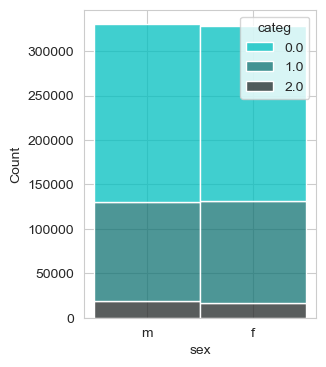

In [1451]:
plt.figure(figsize=(3,4))
sns.histplot(data=tableTotale.sort_values(by='trancheAge'), x='sex', hue='categ',palette="dark:c_r",multiple='stack')